<a href="https://colab.research.google.com/github/MohebZandi/Comupter_Vision/blob/main/FMNIST_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Fashion MNIST


In [ ]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Importing data 

### 1 - from Google Drive

### 2 - from torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_url_train = '/content/gdrive/MyDrive/FMNIST/train-images.gz'
data_url_labels = '/content/gdrive/MyDrive/FMNIST/train-labels.gz'

In [ ]:
# importing data and labels

def training_images():
    with gzip.open(data_url_train, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def training_labels():
    with gzip.open(data_url_labels, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [ ]:
# Shape of the data
print(training_images().shape)

# Shape of labels
print(len(training_labels()))

(60000, 28, 28)
60000


In [ ]:
images = training_images()
labels = training_labels()
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
print(classes.items())

dict_items([(0, 'T-shirt/top'), (1, 'Trouser'), (2, 'Pullover'), (3, 'Dress'), (4, 'Coat'), (5, 'Sandal'), (6, 'Shirt'), (7, 'Sneaker'), (8, 'Bag'), (9, 'Ankle boot')])


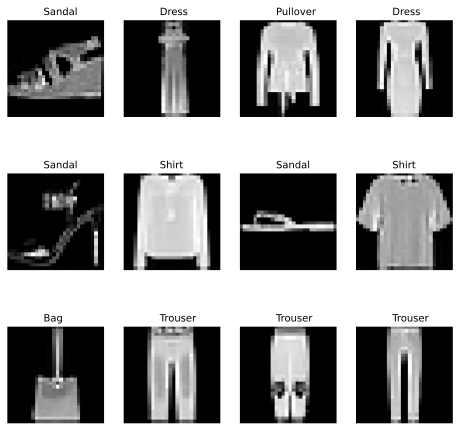

In [ ]:
fig, axs = plt.subplots(3,4, figsize= (8,8))


for ax in axs.flatten():
    i = np.random.randint(1, 2000, 1 ).item()
    ax.imshow(images[i], cmap= 'gray')
    ax.text(10, -2, classes[labels[i]])
    ax.axis('off')

# plt.imshow(images[1], cmap= 'gray')
plt.show()

### working with data from google drive

In [ ]:
# we already have the data and labels s follow
images = training_images()
labels = training_labels()
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 
           4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

print (type(images))
print(images.shape)
print(' ')
print(type(labels))
print(labels.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)
 
<class 'numpy.ndarray'>
(60000,)


In [ ]:
# let's Normalize the data

dataNorm = images / np.max(images)
print(dataNorm.shape)

print(np.min(images), np.max(images))
print(np.min(dataNorm), np.max(dataNorm))

(60000, 28, 28)
0 255
0.0 1.0


In [ ]:
# now we have to eshape it to (Number of images, number of channels, Number of H pixels, Number of W pixels)

dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)
print(dataNorm.shape)

In [ ]:
# creating train/test groups using dataloader

# step1 : convert to tensor

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# step 2 : we have to split the training and test data using scikit learn function
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT,
                                                                    test_size= 0.1)

# step 3 : convert into PyTorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4 : Create dataloaders
trainloader = DataLoader(train_data, batch_size= 32, shuffle= True, drop_last= True)
testloader = DataLoader(test_data, batch_size= 256)

In [ ]:
# check size (should be images X channels X width X height)
print(trainloader.dataset.tensors[0].shape)
print(testloader.dataset.tensors[0].shape)
print(labelsT.shape)

### Create the NN model function

In [ ]:
def FMNISTmodel(print_option= False):
    class fmnist(nn.Module):
        def __init__(self, print_option):
            super().__init__()

            # convolution layers
            self.convolution1 = nn.Conv2d(1, 10, kernel_size= 5, stride=1, padding= 1)   # size : np.floor((28+ 2*1 -5)/1) + 1 =26  ---> maxpooling 26/2 = 13
            self.convolution2 = nn.Conv2d(10, 20, kernel_size= 5, stride=1, padding= 1)  # size : np.floor((13+ 2*1 -5)/1) + 1 =11  ---> maxpooling 11/2 = 5
            self.convolution3 = nn.Conv2d(20, 40, kernel_size= 3, stride= 1, padding= 1) # size : np.floor((5+ 2*1 -3)/1) + 1 = 5    ---> maxpooling 5/2 = 2
            expectSize = 40* (int((np.floor((5+ 2*1 -3)/1) + 1)/2)**2)
            
            # Fully connected layers
            self.ffn1 = nn.Linear(expectSize, 80)
            self.ffn2 = nn.Linear(80, 50)
            self.output = nn.Linear(50, 10)

            self.print = print_option

        def forward(self, x):

            if self.print : print(x.shape)
            # Convolution Layers
            x = F.leaky_relu(F.max_pool2d(self.convolution1(x), 2))
            if self.print : print(x.shape)
            x = F.leaky_relu(F.max_pool2d(self.convolution2(x), 2))
            if self.print : print(x.shape)
            x = F.leaky_relu(F.max_pool2d(self.convolution3(x), 2))
            if self.print : print(x.shape)

            # reshape the matrix for Linear laye input
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print : print('Vectorized matrix  ',x.shape)

            # Linear Layers
            x = F.leaky_relu(self.ffn1(x))
            if self.print : print(x.shape)
            x = F.leaky_relu(self.ffn2(x))
            if self.print : print(x.shape)
            x = self.output(x)
            if self.print : print(x.shape)

            return x
        
    net = fmnist(print_option)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params = net.parameters(), lr= 0.001, weight_decay= 0.00001)

    return net, lossfun, optimizer

In [ ]:
# test with one batch of data

net, loss, opt = FMNISTmodel(print_option= True)

X, y = next(iter(trainloader))
yHat = net(X)

print('yHat shape:', yHat.shape)
print(y.shape)
print(' ')
lossvalue = loss(yHat, y)
print(lossvalue)

In [ ]:
from torchsummary import summary
# summary(net,(1,28,28))

### Create a function to train the model 

In [ ]:
# Create a model to train the NN model

def trainmodel(number_of_epochs = 1):

    numberepochs = number_of_epochs

    net, lossfun, optimizer = FMNISTmodel(print_option= False)
    net.to(device)

    trainloss = torch.zeros(numberepochs)
    trainAcc = torch.zeros(numberepochs)
    testAcc  = []

    for epoch in range(numberepochs):
        print('Starting epoch is: ', epoch+1)
        net.train()
        batchAcc = []
        batchloss = []

        for X,y in trainloader:

            X = X.to(device)
            y= y.to(device)

            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchloss.append(loss.item())

            # compute accuracy
            matches_bool = torch.argmax(yHat, axis=1) == y        # booleans (false/true)
            matches_numeric = matches_bool.float()                # convert to numbers (0/1)
            accuracy_percent = 100 * torch.mean(matches_numeric)  # average and x100
            batchAcc.append(accuracy_percent.item())

            # end of a batch
        
        trainAcc[epoch] = np.mean(batchAcc).item()
        trainloss[epoch] = np.mean(batchloss).item()

        
        net.eval()
        for X, y in testloader:
            X= X.to(device)
            y= y.to(device)

            batchloss = []
            batchAcc = []
            with torch.no_grad():
                yHat = net(X)
            batchloss.append(lossfun(yHat, y).item())
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
        testAcc.append( np.mean(batchAcc))
        
        print('Number of Epoch finished: ', epoch+1)
        # end of one epoch
    
    return trainAcc, testAcc, trainloss


In [ ]:
%%time
trainAcc , testAcc, trainloss = trainmodel(number_of_epochs = 10)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainloss,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# 2- from torchvision

In [ ]:
# # transformations
# transform = T.Compose([ T.ToTensor(),
#                         T.Normalize([.5,.5,.5],[.5,.5,.5])
#                        ])

# trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
# devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# print(trainset.data.shape)
# print(devtest.data.shape)
# print(trainset.classes)
# print(len(trainset.classes))
# print(trainset.targets)